## Exploring stereo A and B detections

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

In [2]:
stereo_a_detections = pd.read_csv(f"{root}/data/stereo_A_detections_triangulated.csv")
stereo_b_detections = pd.read_csv(f"{root}/data/stereo_B_detections_triangulated.csv")

# sort them by frame_no
stereo_a_detections = stereo_a_detections.sort_values(by='frame_no')
stereo_b_detections = stereo_b_detections.sort_values(by='frame_no')


In [3]:
print(stereo_a_detections.head(1))

   Unnamed: 0  frame_no  A1_x  A1_y  A1_confidence A1_method  A2_x  A2_y  \
0           0      1021   795   468       0.808076      YOLO  1023   452   

   A2_confidence A2_method                                 position_3d_pixels  \
0       0.502068      YOLO  [-1864.3065328634257, -484.0727254308621, 7931...   

                      A1_reprojected_point  A1_error_cm  \
0  [1587.2223263659757, 934.4073687215065]     0.834419   

                      A2_reprojected_point  A2_error_cm  anomaly_detected  
0  [2045.9062117271465, 905.6761288547647]     0.732834             False  


In [4]:
print(stereo_b_detections.head(1))

   Unnamed: 0  frame_no  B1_x  B1_y  B1_confidence B1_method  B2_x  B2_y  \
0           0      1061    16   374       0.797673      YOLO  1892   383   

   B2_confidence B2_method                                 position_3d_pixels  \
0            0.4        LK  [-4762.258295778171, -866.5098314692611, 4496....   

                    B1_reprojected_point  B1_error_cm  \
0  [91.04262030378325, 762.119344613008]     0.655213   

                    B2_reprojected_point  B2_error_cm  anomaly_detected  
0  [3721.7838418900033, 776.60757086892]     0.648677             False  


In [5]:
print(len(stereo_a_detections))
print(len(stereo_b_detections))

if len(stereo_a_detections) > len(stereo_b_detections):
    # If A is longer, cut A to match B's length
    stereo_a_detections = stereo_a_detections.iloc[:len(stereo_b_detections)]
else:
    # If B is longer, cut B to match A's length
    stereo_b_detections = stereo_b_detections.iloc[:len(stereo_a_detections)]

print(len(stereo_a_detections))
print(len(stereo_b_detections))

225
205
205
205


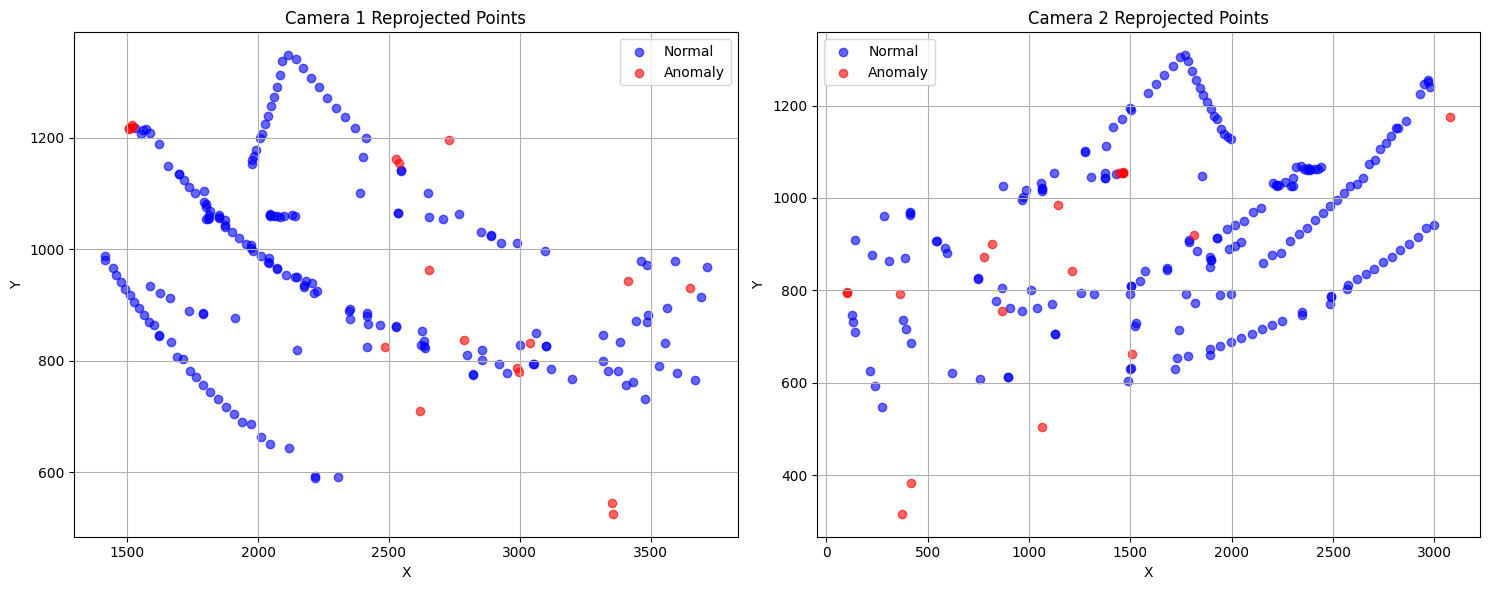

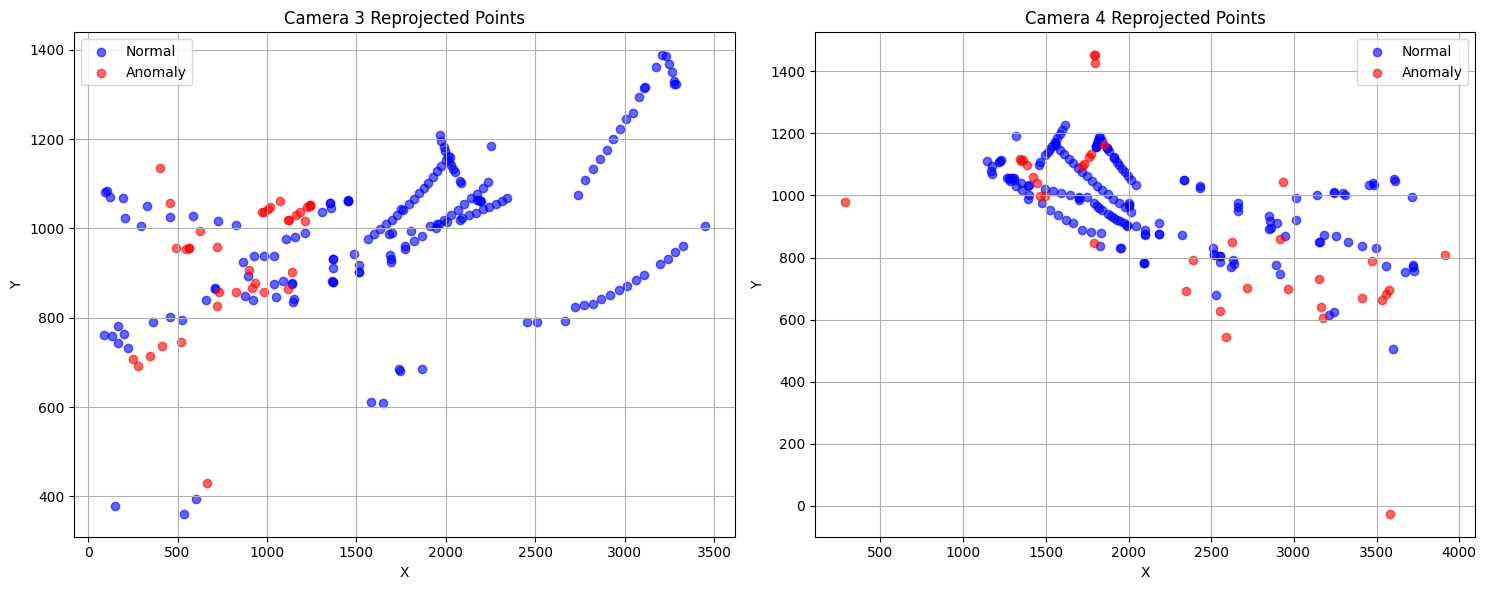

In [6]:
from plots import plot_2d_reprojected_points

plot_2d_reprojected_points(stereo_a_detections, stereo='A', camera_names=['Camera 1', 'Camera 2'])
plot_2d_reprojected_points(stereo_b_detections, stereo='B', camera_names=['Camera 3', 'Camera 4'])


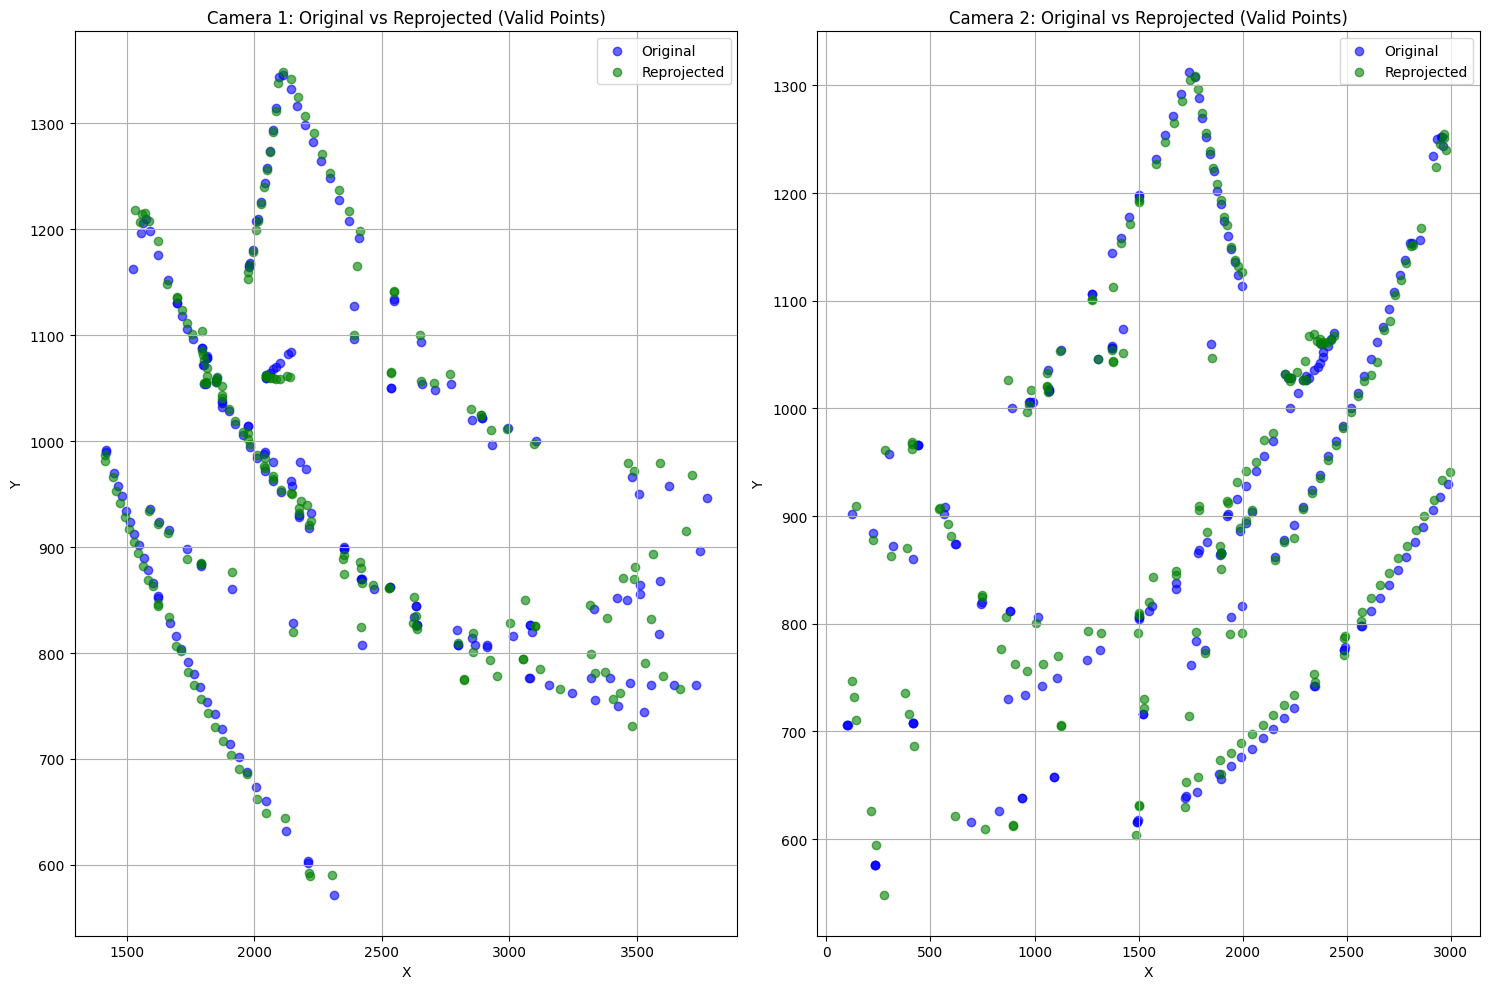

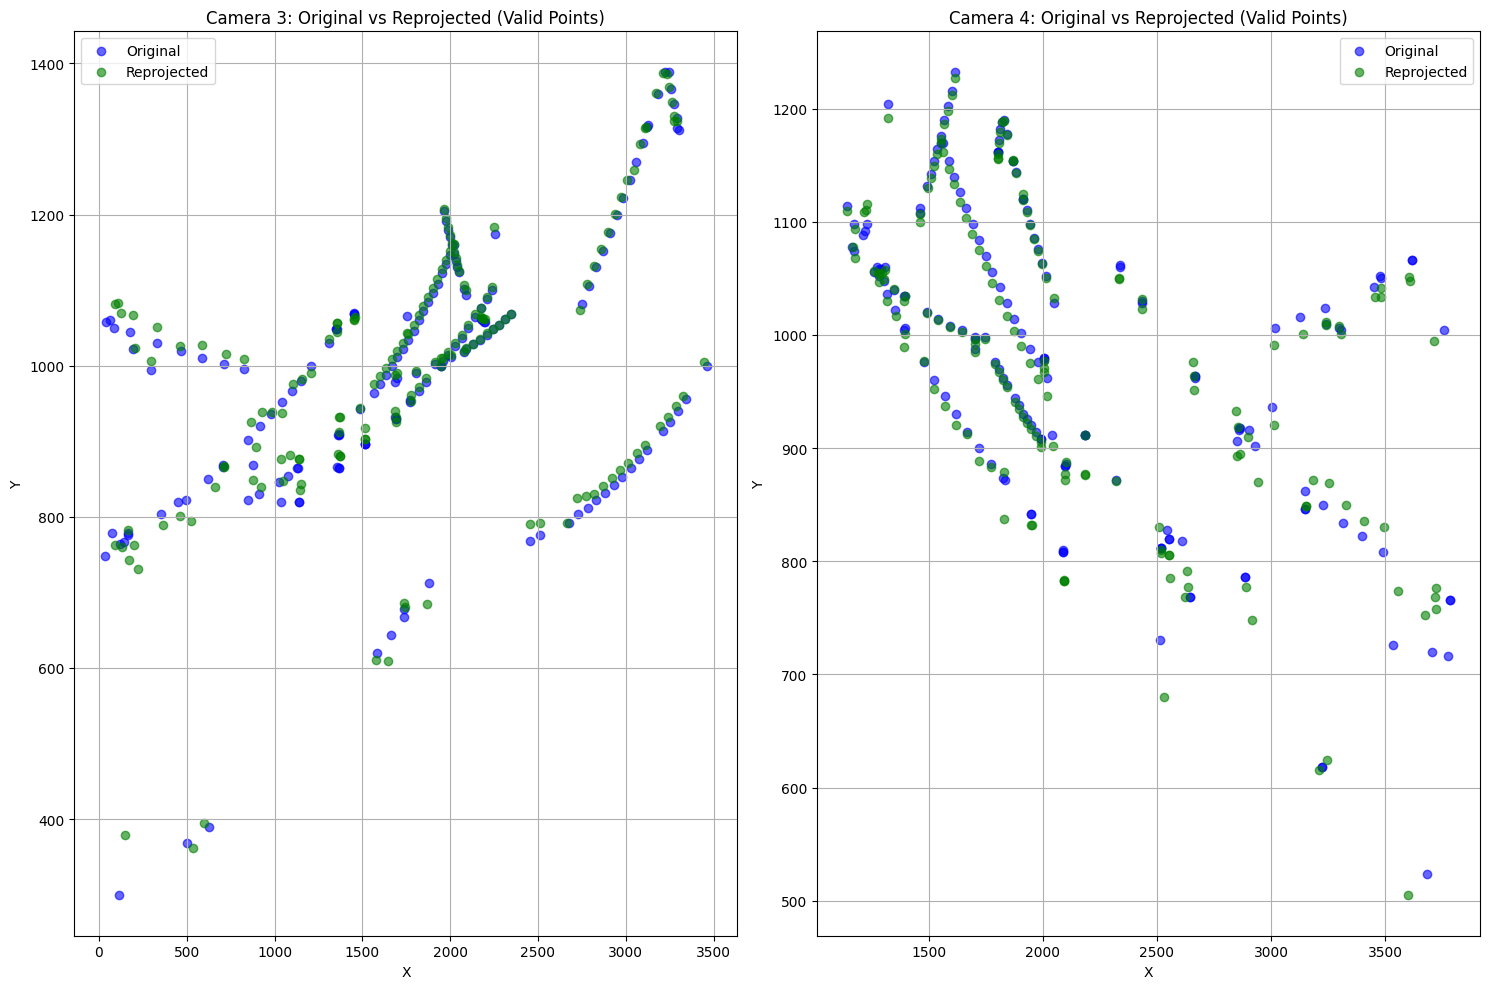

In [7]:
from plots import plot_valid_vs_original, plot_anomaly_vs_original

plot_valid_vs_original(stereo_a_detections, stereo='A', camera_names=['Camera 1', 'Camera 2'])
plot_valid_vs_original(stereo_b_detections, stereo='B', camera_names=['Camera 3', 'Camera 4'])


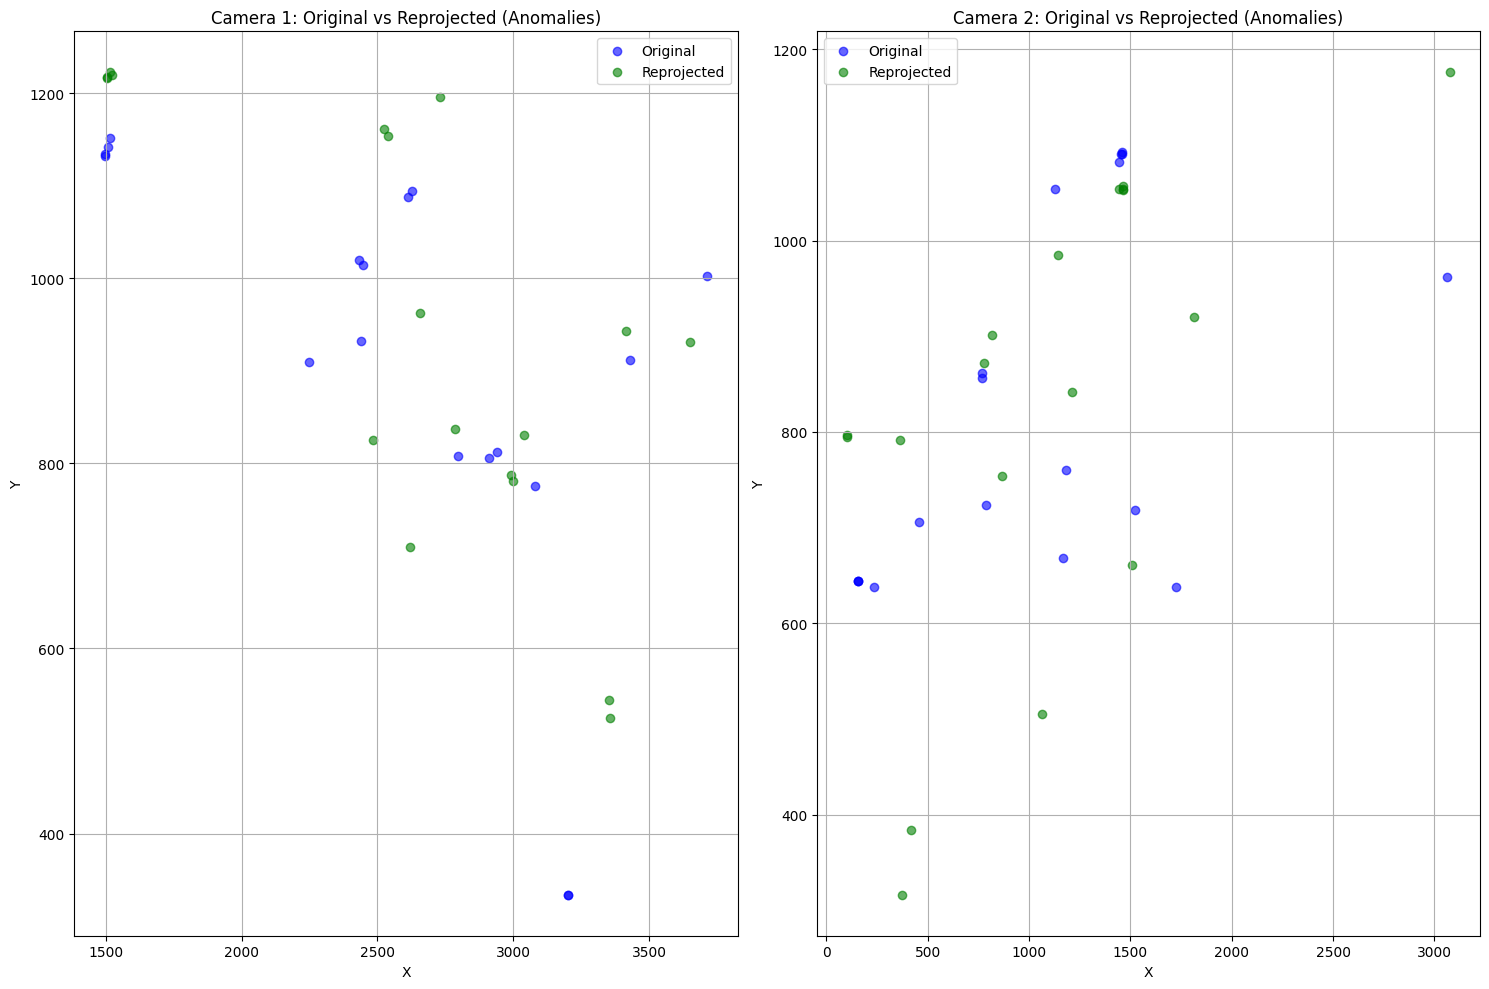

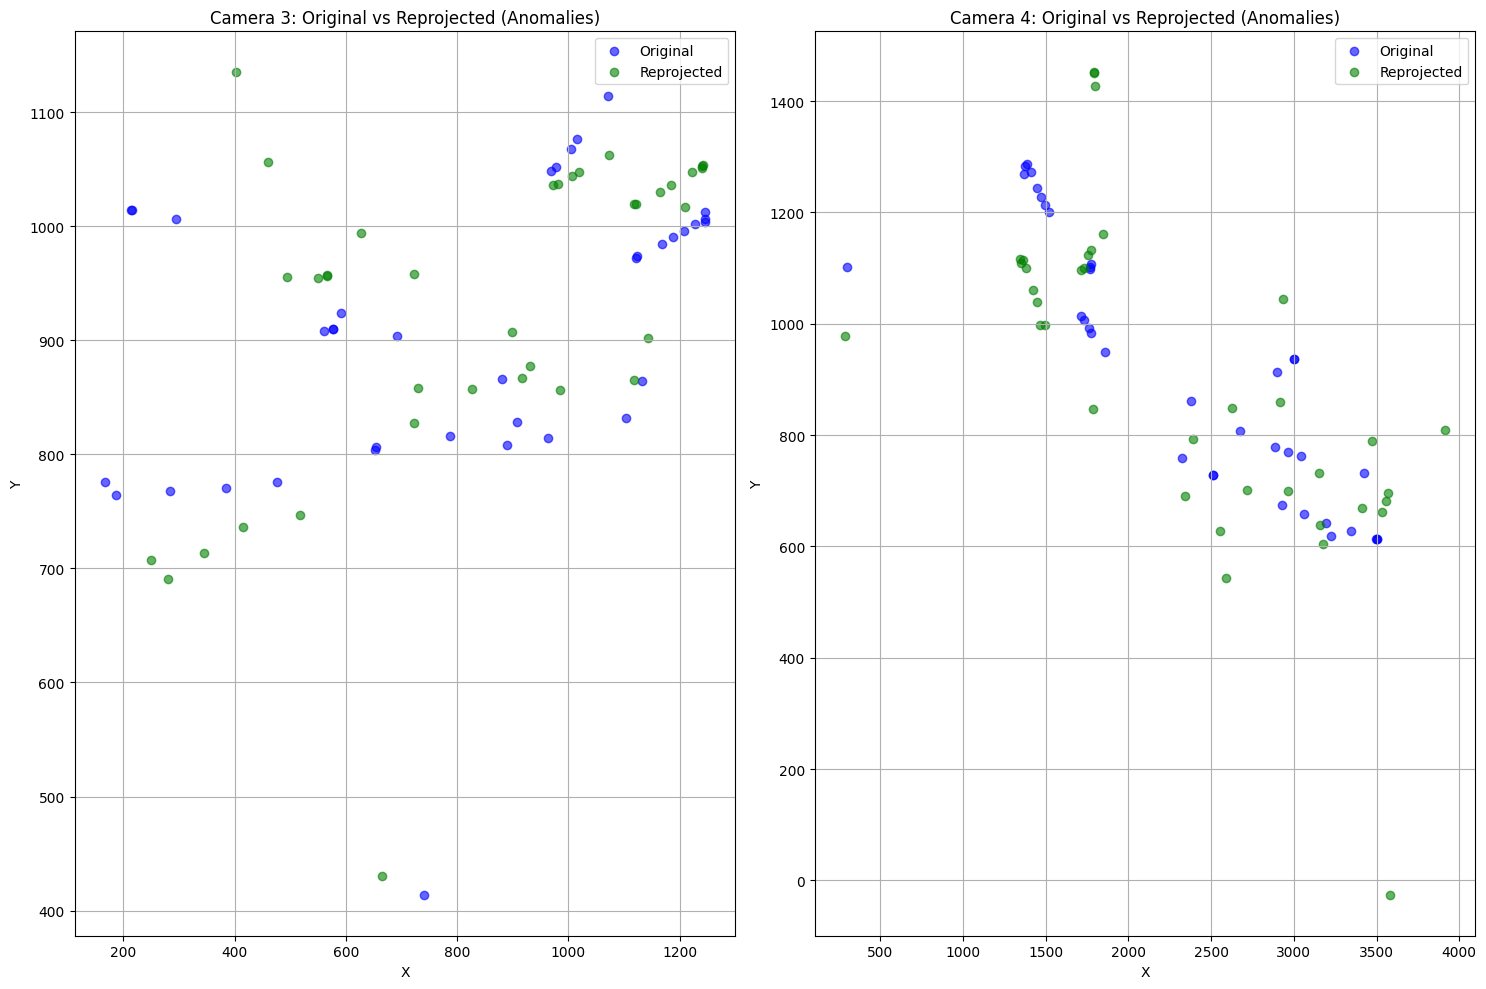

In [8]:
plot_anomaly_vs_original(stereo_a_detections, stereo='A', camera_names=['Camera 1', 'Camera 2'])
plot_anomaly_vs_original(stereo_b_detections, stereo='B', camera_names=['Camera 3', 'Camera 4'])

## Find shot sequences

In [9]:
import pandas as pd

def find_shot_sequence(dfA, dfB, error_threshold=5, gap_threshold=10, n_frames=20):
    dfA = dfA[(~dfA.anomaly_detected) & (dfA.A1_error_cm < error_threshold) & (dfA.A2_error_cm < error_threshold)].sort_values('frame_no')
    dfB = dfB[(~dfB.anomaly_detected) & (dfB.B1_error_cm < error_threshold) & (dfB.B2_error_cm < error_threshold)].sort_values('frame_no')
    best_gap = float('inf')
    best_pair = None
    for fB in dfB['frame_no']:
        cand = dfA[dfA['frame_no'] > fB]
        if cand.empty:
            continue
        gap = cand.iloc[0]['frame_no'] - fB
        if gap < best_gap and gap <= gap_threshold:
            best_gap = gap
            best_pair = (fB, cand.iloc[0]['frame_no'])
    if best_pair:
        shotB = dfB[dfB['frame_no'] <= best_pair[0]].tail(n_frames)
        shotA = dfA[dfA['frame_no'] >= best_pair[1]].head(n_frames)
        return shotB, shotA
    return None, None

shotB, shotA = find_shot_sequence(stereo_a_detections, stereo_b_detections)


In [10]:
def save_frames(df, stereo_name, frames_folder, output_path):
  for index, row in df.iterrows():
    frame_no = row['frame_no']
    frame_folder = f"{frames_folder}/frame_{frame_no}"
    if stereo_name == 'A':
        cam_frame = f"{frame_folder}/2_{frame_no}.jpg"
    else:
        cam_frame = f"{frame_folder}/4_{frame_no}.jpg"

    cam_frame = cv2.imread(cam_frame)
    # save the image with the index as the filename
    sub_folder_name = "first" if stereo_name == 'B' else "after"
    save_path = f"{output_path}/{sub_folder_name}/{index}.jpg"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, cam_frame)

save_frames(shotB, 'B', f"{root}/matched_stereo_frames", f"{root}/shots/1")
save_frames(shotA, 'A', f"{root}/matched_stereo_frames", f"{root}/shots/1")


In [11]:
# save shotB and shotA as csvs
shotB.to_csv(f"{root}/data/shots/1/shotB_first.csv", index=False)
shotA.to_csv(f"{root}/data/shots/1/shotA_after.csv", index=False)